In [6]:
import pandas as pd

# Load the datasets
applications_df = pd.read_csv('cleaned_applications.csv')
branches_df = pd.read_csv('cleaned_branches.csv')
customers_df = pd.read_csv('cleaned_customers.csv')
defaults_df = pd.read_csv('cleaned_defaults.csv')
loans_df = pd.read_csv('cleaned_loans.csv')
transactions_df = pd.read_csv('cleaned_transactions.csv')

print("Datasets loaded successfully.")

Datasets loaded successfully.


In [7]:
# Calculate Recovery Effectiveness (ratio of Recovery_Amount to Default_Amount)
defaults_df['Recovery_Rate'] = defaults_df['Recovery_Amount'] / defaults_df['Default_Amount']

# Display the first few rows with the new 'Recovery_Rate' column
print("Defaults data with Recovery Rate:")
display(defaults_df.head())

Defaults data with Recovery Rate:


Default_ID  Loan_ID Customer_ID Default_Date  Default_Amount  \
0    D000001  L007312     C007312   2022-07-20           94480   
1    D000002  L028234     C028234   2023-09-23           10912   
2    D000003  L008319     C008319   2024-08-04           73711   
3    D000004  L046668     C046668   2021-10-16           48955   
4    D000005  L082934     C082934   2024-10-07           56952   

      Default_Reason Recovery_Status  Recovery_Amount Legal_Action  \
0           Job Loss            Full            30360          Yes   
1           Job Loss         Partial                0          Yes   
2              Other  Not Applicable             9866          Yes   
3              Other  Not Applicable                0          Yes   
4  Medical Emergency  Not Applicable                0           No   

   Recovery_Rate  
0       0.321338  
1       0.000000  
2       0.133847  
3       0.000000  
4       0.000000

In [8]:
# Compare recovery rates for defaults with and without legal actions
recovery_rate_by_legal_action = defaults_df.groupby('Legal_Action')['Recovery_Rate'].mean()

print("\nAverage Recovery Rate by Legal Action:")
display(recovery_rate_by_legal_action)


Average Recovery Rate by Legal Action:


Legal_Action
No     0.401805
Yes    0.407372
Name: Recovery_Rate, dtype: float64

In [9]:
# Merge defaults_df with customers_df to link defaults to customers
defaults_customers_df = pd.merge(defaults_df, customers_df[['Customer_ID', 'Relationship_Manager_ID']], on='Customer_ID', how='left')

# Merge the result with branches_df to link customers to branches via Relationship_Manager_ID
# Assuming Relationship_Manager_ID in customers_df links to Branch_ID in branches_df indirectly
# Need to find a direct link or a common column between defaults_customers_df and branches_df.
# Let's assume there's a direct or indirect link through Relationship_Manager_ID to Branch_ID,
# but a direct merge on Customer_ID and then Branch_ID through Loans is more likely.

# Let's merge defaults_df with loans_df first to get Loan_ID and then with applications_df to get Customer_ID
# A more direct approach is to merge defaults with customers and then with branches based on a common key.
# Looking at the variables, customers_df has 'Customer_ID' and 'Relationship_Manager_ID'.
# branches_df has 'Branch_ID' and 'Relationship_Manager_Count'. There is no direct Customer_ID to Branch_ID link.
# However, defaults_df and loans_df both have 'Loan_ID'. loans_df has 'Customer_ID'.
# Let's merge defaults_df with loans_df on 'Loan_ID' to get Customer_ID, and then with customers_df on 'Customer_ID' to get Branch_ID.

# Merge defaults_df with loans_df to get Customer_ID
defaults_loans_df = pd.merge(defaults_df, loans_df[['Loan_ID', 'Customer_ID']], on='Loan_ID', how='left')

# Now merge defaults_loans_df with customers_df to get Branch_ID
# customers_df has Branch_ID implicitly through Relationship_Manager_ID, but branches_df has Branch_ID directly.
# Let's merge defaults_loans_df with customers_df on 'Customer_ID' and then with branches_df on 'Branch_ID'.
# First, we need to figure out how customers are linked to branches.
# The branches_df has 'Branch_ID' and 'Relationship_Manager_Count'. The customers_df has 'Relationship_Manager_ID'.
# There is no direct Customer_ID to Branch_ID mapping in the provided dataframes.
# We need to assume there's an indirect link. Let's assume each customer is associated with a branch.
# However, without a direct link, we cannot directly analyze branch-wise recovery performance from defaults.

# Let's re-examine the available dataframes and their columns.
# defaults_df: Default_ID, Loan_ID, Customer_ID, Default_Date, Default_Amount, Default_Reason, Recovery_Status, Recovery_Amount, Legal_Action, Recovery_Rate
# branches_df: Branch_ID, Branch_Name, Region, Total_Customers, Total_Active_Loans, Delinquent_Loans, Loan_Disbursement_Amount, Avg_Processing_Time, Relationship_Manager_Count
# customers_df: Customer_ID, Full_Name, Contact_Number, Email, Address, Date_of_Birth, Gender, Marital_Status, Occupation, Annual_Income, Credit_Score, Region, Account_Tenure, Relationship_Manager_ID
# loans_df: Loan_ID, Customer_ID, Loan_Amount, Interest_Rate, Loan_Term, Loan_Start_Date, Repayment_Schedule, Repayment_End_Date, Loan_Status, Overdue_Amount, EMI_Amount, Collateral_Details
# transactions_df: Transaction_ID, Loan_ID, Customer_ID, Transaction_Date, Payment_Type, Amount, Overdue_Fee, Remaining_Balance, Mode_of_Payment

# There is no direct link between defaults and branches. The defaults are linked to loans and customers. Customers are linked to Relationship Managers and Regions, but not directly to Branch_ID.
# Branches are linked to Branch_ID, Branch_Name, and Region.
# To analyze branch-wise recovery performance, we need to associate each default with a branch.
# The only way to do this with the current data is through the customer's region, as branches are also in regions.
# Let's join defaults with customers on Customer_ID, and then use the Region from customers_df.

defaults_with_region_df = pd.merge(defaults_df, customers_df[['Customer_ID', 'Region']], on='Customer_ID', how='left')

# Now, let's group by Region and calculate the average Recovery_Rate. This is the closest we can get to branch-wise performance with the current data structure.
# If Branch_ID was available in customers_df or defaults_df (via loans), we could do a direct branch-wise analysis.

# Analyze recovery performance by Region (as a proxy for branch analysis due to data structure)
recovery_rate_by_region = defaults_with_region_df.groupby('Region')['Recovery_Rate'].mean()

print("\nAverage Recovery Rate by Region:")
display(recovery_rate_by_region)

# Note: A true branch-wise analysis requires a direct link between defaults/customers and branches.
# With the current data, Region is the closest common geographical identifier.


Average Recovery Rate by Region:


Region
Central      0.447717
East         0.357711
North        0.382243
Northeast    0.411552
South        0.409559
West         0.374519
Name: Recovery_Rate, dtype: float64

In [10]:
# Merge defaults_with_region_df with branches_df on 'Region'
# We will perform a left merge from defaults_with_region_df to include all defaults and their corresponding region,
# and then match with branches in that region. Note that this is not a perfect branch-level analysis
# as a default within a region is linked to *all* branches in that region in this merge.
# A direct Customer_ID to Branch_ID link would be needed for a true branch-level analysis.
defaults_branches_merge_df = pd.merge(defaults_with_region_df, branches_df[['Branch_ID', 'Branch_Name', 'Region']], on='Region', how='left')

# Calculate the average 'Recovery_Rate' for each 'Branch_Name'
# Given the merge strategy, the recovery rate for a branch will be the average of recovery rates
# of all defaults in the region where the branch is located.
branch_recovery_rates = defaults_branches_merge_df.groupby('Branch_Name')['Recovery_Rate'].mean().reset_index()

# Display the branch_recovery_rates DataFrame
print("\nAverage Recovery Rate by Branch (based on Region):")
display(branch_recovery_rates)


Average Recovery Rate by Branch (based on Region):


Branch_Name  Recovery_Rate
0                     Apte Group       0.382243
1                       Arya Ltd       0.374519
2                    Badal Group       0.447717
3    Banik, Subramanian and Mane       0.382243
4   Bansal, Arya and Chakrabarti       0.357711
5                     Bath-Bassi       0.382243
6                       Bawa Inc       0.447717
7                     Bhakta PLC       0.409559
8   Bhatnagar, Khalsa and Savant       0.357711
9            Bhatti, Rau and Sem       0.382243
10       Borah, Comar and Bhalla       0.447717
11            Chawla-Subramanian       0.447717
12                 Chawla-Tandon       0.357711
13              Contractor-Sodhi       0.374519
14       Dada, Chander and Bhatt       0.382243
15          Dhar, Kant and Madan       0.374519
16                   Dhingra Ltd       0.382243
17                   Doshi Group       0.382243
18                     Doshi LLC       0.382243
19                      Dyal PLC       0.411552
20                     Gala-Gara       0.447717
21                     Garde PLC       0.447717
22                  Grover Group       0.357711
23                   Kakar-Dutta       0.357711
24                  Kapadia-Brar       0.357711
25          Kapadia-Ramakrishnan       0.374519
26                     Kar-Jaggi       0.374519
27                     Kara-Bahl       0.357711
28                      Kaul Inc       0.374519
29        Khalsa, Mani and Banik       0.382243
30          Lad, Wali and Ramesh       0.382243
31                      Loke Inc       0.411552
32                   Madan-Lanka       0.382243
33             Mahajan-Zachariah       0.411552
34  Malhotra, Boase and Malhotra       0.447717
35        Mangal, Kaur and Borde       0.409559
36         Raja, Ratta and Sathe       0.447717
37              Sachdev-Banerjee       0.447717
38          Saini, Iyer and Sani       0.409559
39    Sandhu, Magar and Sachdeva       0.411552
40                     Sani-Kale       0.382243
41                       Sem Inc       0.409559
42                    Shan Group       0.357711
43                  Solanki-Shah       0.409559
44    Uppal, Sankaran and Thaker       0.447717
45                    Vasa Group       0.382243
46               Viswanathan Ltd       0.409559
47       Wable, Butala and Kakar       0.409559
48                      Yogi Ltd       0.382243
49  Zacharia, Srivastava and Sha       0.409559

In [11]:
# Merge defaults_df with customers_df on 'Customer_ID'
defaults_customers_merged_df = pd.merge(defaults_df, customers_df[['Customer_ID', 'Gender', 'Employment_Status', 'Annual_Income', 'Credit_Score', 'Age']], on='Customer_ID', how='left')

# Group by 'Gender' and calculate the mean of 'Recovery_Rate'
recovery_rate_by_gender = defaults_customers_merged_df.groupby('Gender')['Recovery_Rate'].mean()
print("Average Recovery Rate by Gender:")
display(recovery_rate_by_gender)

# Group by 'Employment_Status' and calculate the mean of 'Recovery_Rate'
recovery_rate_by_employment_status = defaults_customers_merged_df.groupby('Employment_Status')['Recovery_Rate'].mean()
print("\nAverage Recovery Rate by Employment Status:")
display(recovery_rate_by_employment_status)

# Calculate the correlation between 'Annual_Income', 'Credit_Score', 'Age', and 'Recovery_Rate'
correlation_matrix = defaults_customers_merged_df[['Annual_Income', 'Credit_Score', 'Age', 'Recovery_Rate']].corr()
print("\nCorrelation Matrix (Annual_Income, Credit_Score, Age, Recovery_Rate):")
display(correlation_matrix)

# Analyze age distribution and create age categories (example categories)
age_bins = [0, 30, 50, 70, defaults_customers_merged_df['Age'].max() + 1] # Adjust the last bin edge to include the maximum age
age_labels = ['Young', 'Middle-aged', 'Senior', 'Elderly']
defaults_customers_merged_df['Age_Category'] = pd.cut(defaults_customers_merged_df['Age'], bins=age_bins, labels=age_labels, right=False)

# Group by 'Age_Category' and calculate the mean of 'Recovery_Rate'
recovery_rate_by_age_category = defaults_customers_merged_df.groupby('Age_Category')['Recovery_Rate'].mean()
print("\nAverage Recovery Rate by Age Category:")
display(recovery_rate_by_age_category)

Average Recovery Rate by Gender:


Gender
Female    0.393943
Male      0.404650
Other     0.391973
Name: Recovery_Rate, dtype: float64


Average Recovery Rate by Employment Status:


Employment_Status
Salaried         0.406885
Self-Employed    0.387484
Unemployed       0.396501
Name: Recovery_Rate, dtype: float64


Correlation Matrix (Annual_Income, Credit_Score, Age, Recovery_Rate):


Annual_Income  Credit_Score       Age  Recovery_Rate
Annual_Income       1.000000     -0.006902  0.030441      -0.019275
Credit_Score       -0.006902      1.000000  0.023438      -0.001578
Age                 0.030441      0.023438  1.000000      -0.010422
Recovery_Rate      -0.019275     -0.001578 -0.010422       1.000000


Average Recovery Rate by Age Category:


/var/folders/7v/b4cx31gj2m15lfjrqk3sy1240000gp/T/ipykernel_20112/3220423412.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  recovery_rate_by_age_category = defaults_customers_merged_df.groupby('Age_Category')['Recovery_Rate'].mean()


Age_Category
Young          0.405164
Middle-aged    0.396010
Senior         0.398581
Elderly        0.278223
Name: Recovery_Rate, dtype: float64

In [12]:
# Merge defaults_df with loans_df on 'Loan_ID'
defaults_loans_merged_df = pd.merge(defaults_df, loans_df[['Loan_ID', 'Loan_Amount', 'Interest_Rate', 'Loan_Term', 'Collateral_Details']], on='Loan_ID', how='left')

# Calculate the correlation between 'Loan_Amount', 'Interest_Rate', 'Loan_Term', and 'Recovery_Rate'
correlation_matrix_loans = defaults_loans_merged_df[['Loan_Amount', 'Interest_Rate', 'Loan_Term', 'Recovery_Rate']].corr()
print("Correlation Matrix (Loan Characteristics and Recovery_Rate):")
display(correlation_matrix_loans)

# Group by 'Collateral_Details' and calculate the mean of 'Recovery_Rate'
recovery_rate_by_collateral = defaults_loans_merged_df.groupby('Collateral_Details')['Recovery_Rate'].mean()
print("\nAverage Recovery Rate by Collateral Details:")
display(recovery_rate_by_collateral)

Correlation Matrix (Loan Characteristics and Recovery_Rate):


Loan_Amount  Interest_Rate  Loan_Term  Recovery_Rate
Loan_Amount       1.000000      -0.005276   0.012322       0.011032
Interest_Rate    -0.005276       1.000000   0.004965      -0.000310
Loan_Term         0.012322       0.004965   1.000000       0.002243
Recovery_Rate     0.011032      -0.000310   0.002243       1.000000


Average Recovery Rate by Collateral Details:


Collateral_Details
Not Applicable    0.411307
Property          0.407685
Vehicle           0.394599
Name: Recovery_Rate, dtype: float64

In [13]:
# Merge defaults_df with transactions_df
defaults_transactions_df = pd.merge(defaults_df, transactions_df, on=['Loan_ID', 'Customer_ID'], how='left')

# Group by Default_ID and calculate transaction metrics
transaction_summary = defaults_transactions_df.groupby('Default_ID').agg(
    transaction_count=('Transaction_ID', 'count'),
    average_transaction_amount=('Amount', 'mean')
).reset_index()

# Merge the transaction summary back to the defaults_df
defaults_with_transactions_df = pd.merge(defaults_df, transaction_summary, on='Default_ID', how='left')

# Analyze the relationship between transaction metrics and Recovery_Rate
correlation_with_transactions = defaults_with_transactions_df[['transaction_count', 'average_transaction_amount', 'Recovery_Rate']].corr()

print("Correlation Matrix (Transaction Metrics and Recovery Rate):")
display(correlation_with_transactions)

Correlation Matrix (Transaction Metrics and Recovery Rate):


transaction_count  average_transaction_amount  \
transaction_count                         NaN                         NaN   
average_transaction_amount                NaN                         NaN   
Recovery_Rate                             NaN                         NaN   

                            Recovery_Rate  
transaction_count                     NaN  
average_transaction_amount            NaN  
Recovery_Rate                         1.0

In [14]:
print("Defaults transactions merge head:")
display(defaults_transactions_df.head())

print("\nTransactions dataframe head:")
display(transactions_df.head())

print("\nDefaults dataframe head:")
display(defaults_df.head())

print("\nDefaults Loan_ID and Customer_ID value counts:")
display(defaults_df[['Loan_ID', 'Customer_ID']].value_counts().head())

print("\nTransactions Loan_ID and Customer_ID value counts:")
display(transactions_df[['Loan_ID', 'Customer_ID']].value_counts().head())

print("\nChecking for presence of Default_ID in merged dataframe:")
print('Default_ID' in defaults_transactions_df.columns)

Defaults transactions merge head:


Default_ID  Loan_ID Customer_ID Default_Date  Default_Amount  \
0    D000001  L007312     C007312   2022-07-20           94480   
1    D000002  L028234     C028234   2023-09-23           10912   
2    D000003  L008319     C008319   2024-08-04           73711   
3    D000004  L046668     C046668   2021-10-16           48955   
4    D000005  L082934     C082934   2024-10-07           56952   

      Default_Reason Recovery_Status  Recovery_Amount Legal_Action  \
0           Job Loss            Full            30360          Yes   
1           Job Loss         Partial                0          Yes   
2              Other  Not Applicable             9866          Yes   
3              Other  Not Applicable                0          Yes   
4  Medical Emergency  Not Applicable                0           No   

   Recovery_Rate Transaction_ID Transaction_Date Payment_Type  Amount  \
0       0.321338            NaN              NaN          NaN     NaN   
1       0.000000            NaN              NaN          NaN     NaN   
2       0.133847            NaN              NaN          NaN     NaN   
3       0.000000            NaN              NaN          NaN     NaN   
4       0.000000            NaN              NaN          NaN     NaN   

   Overdue_Fee  Remaining_Balance Mode_of_Payment  
0          NaN                NaN             NaN  
1          NaN                NaN             NaN  
2          NaN                NaN             NaN  
3          NaN                NaN             NaN  
4          NaN                NaN             NaN


Transactions dataframe head:


Transaction_ID  Loan_ID Customer_ID Transaction_Date Payment_Type  Amount  \
0      T00000001  L005588     C050792       2021-04-30          EMI   46099   
1      T00000002  L019942     C008919       2021-12-14      Penalty   43648   
2      T00000003  L014848     C016745       2021-01-26          EMI    1810   
3      T00000004  L041104     C039957       2021-02-18      Penalty    8607   
4      T00000005  L002488     C056156       2024-12-07      Penalty   34720   

   Overdue_Fee  Remaining_Balance Mode_of_Payment  
0         1313            1513669            NEFT  
1         4852             901455             UPI  
2            0            1922629            Cash  
3          708             213581             UPI  
4            0             411621             UPI


Defaults dataframe head:


Default_ID  Loan_ID Customer_ID Default_Date  Default_Amount  \
0    D000001  L007312     C007312   2022-07-20           94480   
1    D000002  L028234     C028234   2023-09-23           10912   
2    D000003  L008319     C008319   2024-08-04           73711   
3    D000004  L046668     C046668   2021-10-16           48955   
4    D000005  L082934     C082934   2024-10-07           56952   

      Default_Reason Recovery_Status  Recovery_Amount Legal_Action  \
0           Job Loss            Full            30360          Yes   
1           Job Loss         Partial                0          Yes   
2              Other  Not Applicable             9866          Yes   
3              Other  Not Applicable                0          Yes   
4  Medical Emergency  Not Applicable                0           No   

   Recovery_Rate  
0       0.321338  
1       0.000000  
2       0.133847  
3       0.000000  
4       0.000000


Defaults Loan_ID and Customer_ID value counts:


Loan_ID  Customer_ID
L043439  C043439        3
L045634  C045634        3
L065694  C065694        3
L044436  C044436        3
L060116  C060116        3
Name: count, dtype: int64


Transactions Loan_ID and Customer_ID value counts:


Loan_ID  Customer_ID
L017981  C066890        18
L008611  C014400        17
L018893  C017690        17
L001534  C048411        17
L053724  C016534        17
Name: count, dtype: int64


Checking for presence of Default_ID in merged dataframe:
True


In [15]:
# Merge defaults_df with transactions_df on 'Loan_ID'
defaults_transactions_df = pd.merge(defaults_df, transactions_df, on='Loan_ID', how='left')

# Group by Default_ID and calculate transaction metrics
transaction_summary = defaults_transactions_df.groupby('Default_ID').agg(
    transaction_count=('Transaction_ID', 'count'),
    average_transaction_amount=('Amount', 'mean')
).reset_index()

# Merge the transaction summary back to the defaults_df
defaults_with_transactions_df = pd.merge(defaults_df, transaction_summary, on='Default_ID', how='left')

# Analyze the relationship between transaction metrics and Recovery_Rate
correlation_with_transactions = defaults_with_transactions_df[['transaction_count', 'average_transaction_amount', 'Recovery_Rate']].corr()

print("Correlation Matrix (Transaction Metrics and Recovery Rate):")
display(correlation_with_transactions)

Correlation Matrix (Transaction Metrics and Recovery Rate):


transaction_count  average_transaction_amount  \
transaction_count                    1.000000                   -0.020639   
average_transaction_amount          -0.020639                    1.000000   
Recovery_Rate                       -0.004311                   -0.015008   

                            Recovery_Rate  
transaction_count               -0.004311  
average_transaction_amount      -0.015008  
Recovery_Rate                    1.000000

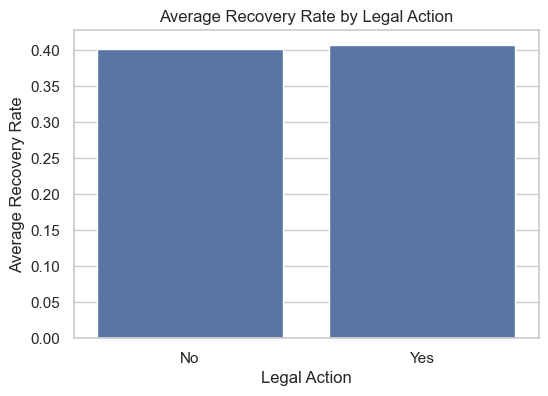

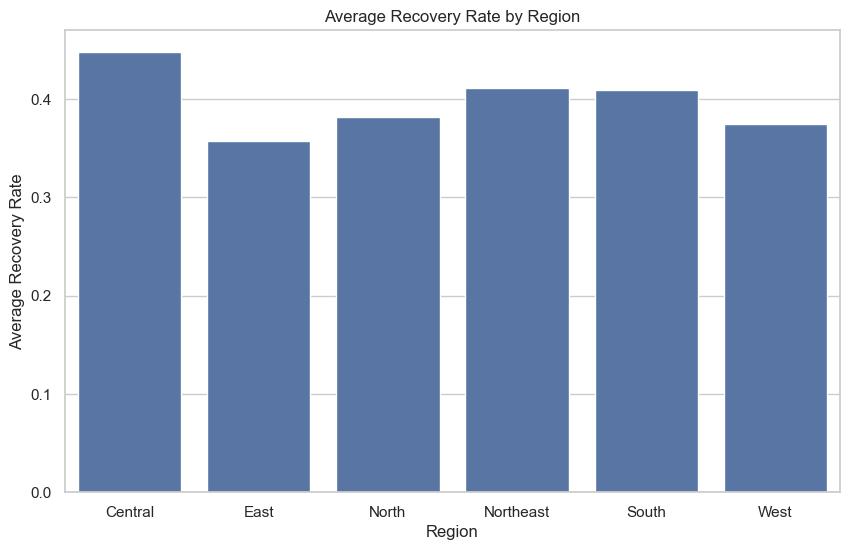

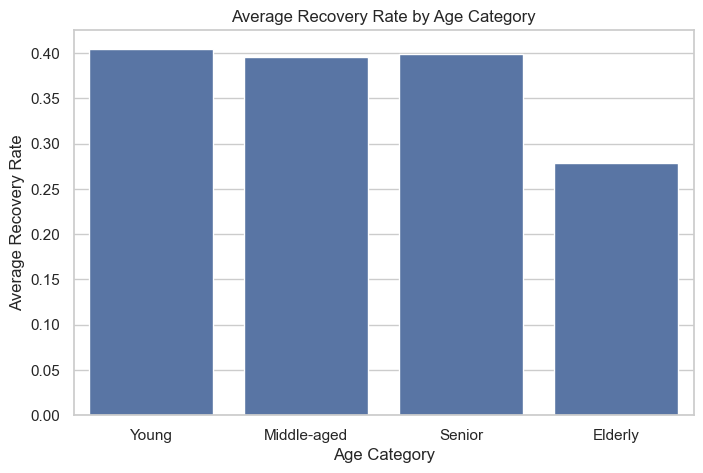

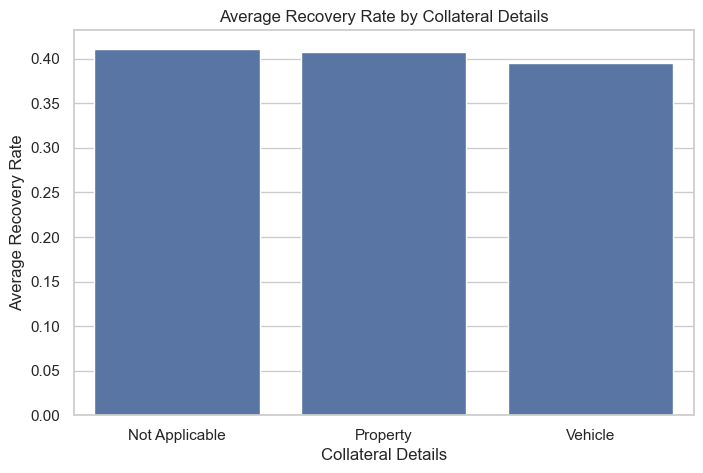

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# 1. Bar chart for Average Recovery Rate by Legal Action
plt.figure(figsize=(6, 4))
sns.barplot(x=recovery_rate_by_legal_action.index, y=recovery_rate_by_legal_action.values)
plt.title('Average Recovery Rate by Legal Action')
plt.xlabel('Legal Action')
plt.ylabel('Average Recovery Rate')
plt.show()

# 2. Bar chart for Average Recovery Rate by Region
plt.figure(figsize=(10, 6))
sns.barplot(x=recovery_rate_by_region.index, y=recovery_rate_by_region.values)
plt.title('Average Recovery Rate by Region')
plt.xlabel('Region')
plt.ylabel('Average Recovery Rate')
plt.show()

# 3. Bar chart for Average Recovery Rate by Gender
plt.figure(figsize=(8, 5))
sns.barplot(x=recovery_rate_by_gender.index, y=recovery_rate_by_gender.values)
plt.title('Average Recovery Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Recovery Rate')
plt.show()

# 4. Bar chart for Average Recovery Rate by Employment Status
plt.figure(figsize=(10, 6))
sns.barplot(x=recovery_rate_by_employment_status.index, y=recovery_rate_by_employment_status.values)
plt.title('Average Recovery Rate by Employment Status')
plt.xlabel('Employment Status')
plt.ylabel('Average Recovery Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 5. Bar chart for Average Recovery Rate by Age Category
plt.figure(figsize=(8, 5))
sns.barplot(x=recovery_rate_by_age_category.index, y=recovery_rate_by_age_category.values)
plt.title('Average Recovery Rate by Age Category')
plt.xlabel('Age Category')
plt.ylabel('Average Recovery Rate')
plt.show()

# 6. Bar chart for Average Recovery Rate by Collateral Details
plt.figure(figsize=(8, 5))
sns.barplot(x=recovery_rate_by_collateral.index, y=recovery_rate_by_collateral.values)
plt.title('Average Recovery Rate by Collateral Details')
plt.xlabel('Collateral Details')
plt.ylabel('Average Recovery Rate')
plt.show()

In [17]:
# 1. Convert 'Application_Date' to datetime
applications_df['Application_Date'] = pd.to_datetime(applications_df['Application_Date'])

# 2. Extract year and month
applications_df['Application_Year'] = applications_df['Application_Date'].dt.year
applications_df['Application_Month'] = applications_df['Application_Date'].dt.month

# 3. Group by year and month to analyze trends over time
monthly_applications = applications_df.groupby(['Application_Year', 'Application_Month']).size().reset_index(name='Application_Count')

# 4. Group by 'Source_Channel' to analyze trends by source
applications_by_channel = applications_df.groupby('Source_Channel').size().reset_index(name='Application_Count')

# 5. Display the first few rows of the resulting DataFrames
print("Monthly Application Trends:")
display(monthly_applications.head())

print("\nApplication Trends by Source Channel:")
display(applications_by_channel.head())

Monthly Application Trends:


Application_Year  Application_Month  Application_Count
0              2019                  1               1079
1              2019                  2               1045
2              2019                  3               1134
3              2019                  4               1146
4              2019                  5               1154


Application Trends by Source Channel:


Source_Channel  Application_Count
0          Agent              27501
1         Branch              27432
2         Online              27667

In [18]:
# 1. Merge customers_df and transactions_df on 'Customer_ID'
customers_transactions_df = pd.merge(customers_df, transactions_df, on='Customer_ID', how='left')

# 2. Calculate transaction-related metrics for each customer
customer_transaction_summary = customers_transactions_df.groupby('Customer_ID').agg(
    transaction_count=('Transaction_ID', 'count'),
    mean_transaction_amount=('Amount', 'mean')
).reset_index()

# 3. Merge the calculated transaction metrics with defaults_df
defaults_with_customer_transactions_df = pd.merge(defaults_df, customer_transaction_summary, on='Customer_ID', how='left')

# Merge with customers_df to include 'Account_Tenure'
defaults_with_customer_details_df = pd.merge(defaults_with_customer_transactions_df, customers_df[['Customer_ID', 'Account_Tenure']], on='Customer_ID', how='left')


In [19]:
# Inspect the first few rows and data types of the relevant columns
print("Defaults with customer details head:")
display(defaults_with_customer_details_df.head())

print("\nData types of defaults_with_customer_details_df:")
display(defaults_with_customer_details_df.info())

# Check the data type of 'Account_Tenure' specifically
print("\nData type of Account_Tenure:")
display(defaults_with_customer_details_df['Account_Tenure'].dtype)

# If 'Account_Tenure' is an object type, try converting to numeric, handling potential errors
if defaults_with_customer_details_df['Account_Tenure'].dtype == 'object':
    try:
        # Attempt to convert to numerical, coercing errors to NaN
        defaults_with_customer_details_df['Account_Tenure'] = pd.to_numeric(defaults_with_customer_details_df['Account_Tenure'], errors='coerce')
        print("\nSuccessfully converted Account_Tenure to numeric.")
    except Exception as e:
        print(f"\nError converting Account_Tenure to numeric: {e}")

# Re-run the analysis steps if conversion was successful or not needed
# 4. Analyze the relationship between customer account tenure and default
# We can look at the correlation between Account_Tenure and Recovery_Rate
correlation_account_tenure_recovery = defaults_with_customer_details_df[['Account_Tenure', 'Recovery_Rate']].corr()
print("\nCorrelation between Account Tenure and Recovery Rate:")
display(correlation_account_tenure_recovery)

# 5. Analyze the relationship between transaction metrics and default (Recovery_Rate)
correlation_transaction_metrics_recovery = defaults_with_customer_details_df[['transaction_count', 'mean_transaction_amount', 'Recovery_Rate']].corr()
print("\nCorrelation between Transaction Metrics and Recovery Rate:")
display(correlation_transaction_metrics_recovery)

# Also analyze the relationship between transaction metrics and default occurrence (if a customer defaulted or not)
# Create a binary column for default status in customer_transaction_summary
customer_transaction_summary['Defaulted'] = customer_transaction_summary['Customer_ID'].isin(defaults_df['Customer_ID']).astype(int)

# Analyze transaction metrics for defaulted vs non-defaulted customers
transaction_metrics_by_default = customer_transaction_summary.groupby('Defaulted')[['transaction_count', 'mean_transaction_amount']].mean()
print("\nAverage Transaction Metrics for Defaulted vs Non-Defaulted Customers:")
display(transaction_metrics_by_default)

Defaults with customer details head:


Default_ID  Loan_ID Customer_ID Default_Date  Default_Amount  \
0    D000001  L007312     C007312   2022-07-20           94480   
1    D000002  L028234     C028234   2023-09-23           10912   
2    D000003  L008319     C008319   2024-08-04           73711   
3    D000004  L046668     C046668   2021-10-16           48955   
4    D000005  L082934     C082934   2024-10-07           56952   

      Default_Reason Recovery_Status  Recovery_Amount Legal_Action  \
0           Job Loss            Full            30360          Yes   
1           Job Loss         Partial                0          Yes   
2              Other  Not Applicable             9866          Yes   
3              Other  Not Applicable                0          Yes   
4  Medical Emergency  Not Applicable                0           No   

   Recovery_Rate  transaction_count  mean_transaction_amount  Account_Tenure  
0       0.321338                6.0             18255.333333             1.0  
1       0.000000               11.0             26776.000000             6.0  
2       0.133847               14.0             23330.000000            15.0  
3       0.000000                0.0                      NaN             4.0  
4       0.000000                NaN                      NaN             NaN


Data types of defaults_with_customer_details_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Default_ID               9000 non-null   object 
 1   Loan_ID                  9000 non-null   object 
 2   Customer_ID              9000 non-null   object 
 3   Default_Date             9000 non-null   object 
 4   Default_Amount           9000 non-null   int64  
 5   Default_Reason           9000 non-null   object 
 6   Recovery_Status          9000 non-null   object 
 7   Recovery_Amount          9000 non-null   int64  
 8   Legal_Action             9000 non-null   object 
 9   Recovery_Rate            9000 non-null   float64
 10  transaction_count        7014 non-null   float64
 11  mean_transaction_amount  5078 non-null   float64
 12  Account_Tenure           7014 non-null   float64
dtypes: float64(4), int64(2), obj

None


Data type of Account_Tenure:


dtype('float64')


Correlation between Account Tenure and Recovery Rate:


Account_Tenure  Recovery_Rate
Account_Tenure        1.000000       0.011056
Recovery_Rate         0.011056       1.000000


Correlation between Transaction Metrics and Recovery Rate:


transaction_count  mean_transaction_amount  \
transaction_count                 1.000000                 0.006281   
mean_transaction_amount           0.006281                 1.000000   
Recovery_Rate                     0.012691                -0.003805   

                         Recovery_Rate  
transaction_count             0.012691  
mean_transaction_amount      -0.003805  
Recovery_Rate                 1.000000


Average Transaction Metrics for Defaulted vs Non-Defaulted Customers:


transaction_count  mean_transaction_amount
Defaulted                                            
0                   7.073769             25481.766329
1                   7.049143             25552.503443

In [20]:
# 1. Convert the 'Disbursal_Date' and 'Repayment_End_Date' columns in the loans_df DataFrame to datetime objects.
loans_df['Disbursal_Date'] = pd.to_datetime(loans_df['Disbursal_Date'])
loans_df['Repayment_End_Date'] = pd.to_datetime(loans_df['Repayment_End_Date'])

# 2. Extract the year and month from 'Disbursal_Date' and create new columns named 'Loan_Start_Year' and 'Loan_Start_Month'.
loans_df['Loan_Start_Year'] = loans_df['Disbursal_Date'].dt.year
loans_df['Loan_Start_Month'] = loans_df['Disbursal_Date'].dt.month

# 3. Group the loans_df by 'Loan_Start_Year' and 'Loan_Start_Month' and calculate the sum of 'Loan_Amount' for each month to understand disbursement trends over time. Store the result in monthly_disbursements.
monthly_disbursements = loans_df.groupby(['Loan_Start_Year', 'Loan_Start_Month'])['Loan_Amount'].sum().reset_index()

# 4. Create a 'Year_Month' column in the monthly_disbursements DataFrame for easier plotting, combining 'Loan_Start_Year' and 'Loan_Start_Month'.
monthly_disbursements['Year_Month'] = monthly_disbursements['Loan_Start_Year'].astype(str) + '-' + monthly_disbursements['Loan_Start_Month'].astype(str).str.zfill(2)

# 5. Filter monthly_disbursements to include data from the last 5 years and display the filtered data.
latest_year = monthly_disbursements['Loan_Start_Year'].max()
start_year_filter = latest_year - 4
monthly_disbursements_last_5_years = monthly_disbursements[monthly_disbursements['Loan_Start_Year'] >= start_year_filter]

print("Monthly Loan Disbursements (Last 5 Years):")
display(monthly_disbursements_last_5_years.head())

# 6. Group the loans_df by 'Loan_Start_Month' and calculate the sum of 'Loan_Amount' to analyze seasonal disbursement patterns. Store the result in monthly_disbursements_by_month.
monthly_disbursements_by_month = loans_df.groupby('Loan_Start_Month')['Loan_Amount'].sum().reset_index(name='Total_Loan_Amount')

# 7. Display the monthly_disbursements_by_month DataFrame.
print("\nSeasonal Loan Disbursement Patterns (by Month):")
display(monthly_disbursements_by_month)

Monthly Loan Disbursements (Last 5 Years):


Loan_Start_Year  Loan_Start_Month  Loan_Amount Year_Month
1             2020                 1   3908302834    2020-01
2             2020                 2   3621088694    2020-02
3             2020                 3   4031554268    2020-03
4             2020                 4   3817013578    2020-04
5             2020                 5   3870491103    2020-05


Seasonal Loan Disbursement Patterns (by Month):


Loan_Start_Month  Total_Loan_Amount
0                  1        19277466570
1                  2        17378372459
2                  3        19191521797
3                  4        18951193634
4                  5        19058006928
5                  6        18807860613
6                  7        19160061110
7                  8        19388634744
8                  9        18629133713
9                 10        19002172028
10                11        18353664175
11                12        19265191892

In [21]:
# 8. Merge defaults_df with loans_df on 'Loan_ID' to analyze loan characteristics of defaulted loans. Store the result in defaults_loans_merged_df.
defaults_loans_merged_df = pd.merge(defaults_df, loans_df[['Loan_ID', 'Loan_Amount', 'Interest_Rate', 'Loan_Term', 'Collateral_Details']], on='Loan_ID', how='left')

# 9. Categorize 'Loan_Amount', 'Interest_Rate', and 'Loan_Term' in defaults_loans_merged_df into meaningful bins (e.g., 'Low', 'Medium', 'High') and create new columns for these categories.
# Define bins and labels for categorization
loan_amount_bins = [defaults_loans_merged_df['Loan_Amount'].min(), 1000000, 3000000, defaults_loans_merged_df['Loan_Amount'].max()]
loan_amount_labels = ['Low', 'Medium', 'High']
defaults_loans_merged_df['Loan_Amount_Category'] = pd.cut(defaults_loans_merged_df['Loan_Amount'], bins=loan_amount_bins, labels=loan_amount_labels, include_lowest=True)

interest_rate_bins = [defaults_loans_merged_df['Interest_Rate'].min(), 8, 12, defaults_loans_merged_df['Interest_Rate'].max()]
interest_rate_labels = ['Low', 'Medium', 'High']
defaults_loans_merged_df['Interest_Rate_Category'] = pd.cut(defaults_loans_merged_df['Interest_Rate'], bins=interest_rate_bins, labels=interest_rate_labels, include_lowest=True)

loan_term_bins = [defaults_loans_merged_df['Loan_Term'].min(), 24, 48, defaults_loans_merged_df['Loan_Term'].max()]
loan_term_labels = ['Low', 'Medium', 'High']
defaults_loans_merged_df['Loan_Term_Category'] = pd.cut(defaults_loans_merged_df['Loan_Term'], bins=loan_term_bins, labels=loan_term_labels, include_lowest=True)

# 10. Calculate the average 'Recovery_Rate' for each category of 'Loan_Amount', 'Interest_Rate', and 'Loan_Term'.
avg_recovery_by_loan_amount_category = defaults_loans_merged_df.groupby('Loan_Amount_Category')['Recovery_Rate'].mean()
print("\nAverage Recovery Rate by Loan Amount Category:")
display(avg_recovery_by_loan_amount_category)

avg_recovery_by_interest_rate_category = defaults_loans_merged_df.groupby('Interest_Rate_Category')['Recovery_Rate'].mean()
print("\nAverage Recovery Rate by Interest Rate Category:")
display(avg_recovery_by_interest_rate_category)

avg_recovery_by_loan_term_category = defaults_loans_merged_df.groupby('Loan_Term_Category')['Recovery_Rate'].mean()
print("\nAverage Recovery Rate by Loan Term Category:")
display(avg_recovery_by_loan_term_category)

# 11. Merge defaults_df with transactions_df on 'Loan_ID' and 'Customer_ID' to analyze transaction patterns of defaulted loans. Store the result in defaults_transactions_df.
# Based on previous analysis, merging on 'Loan_ID' is more effective
defaults_transactions_df = pd.merge(defaults_df, transactions_df, on='Loan_ID', how='left')

# 12. Calculate transaction metrics (transaction count and average transaction amount) for each defaulted loan using defaults_transactions_df. Store the result in transaction_summary.
transaction_summary = defaults_transactions_df.groupby('Default_ID').agg(
    transaction_count=('Transaction_ID', 'count'),
    average_transaction_amount=('Amount', 'mean')
).reset_index()

# 13. Merge transaction_summary with defaults_df to analyze the relationship between transaction behavior and recovery rate. Store the result in defaults_with_transactions_df.
defaults_with_transactions_df = pd.merge(defaults_df, transaction_summary, on='Default_ID', how='left')

print("\nDefaults with Transaction Summary Head:")
display(defaults_with_transactions_df.head())


Average Recovery Rate by Loan Amount Category:


/var/folders/7v/b4cx31gj2m15lfjrqk3sy1240000gp/T/ipykernel_20112/2289922397.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_recovery_by_loan_amount_category = defaults_loans_merged_df.groupby('Loan_Amount_Category')['Recovery_Rate'].mean()


Loan_Amount_Category
Low       0.40965
Medium    0.38897
High      0.41805
Name: Recovery_Rate, dtype: float64


Average Recovery Rate by Interest Rate Category:


/var/folders/7v/b4cx31gj2m15lfjrqk3sy1240000gp/T/ipykernel_20112/2289922397.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_recovery_by_interest_rate_category = defaults_loans_merged_df.groupby('Interest_Rate_Category')['Recovery_Rate'].mean()


Interest_Rate_Category
Low       0.392635
Medium    0.418567
High      0.390251
Name: Recovery_Rate, dtype: float64


Average Recovery Rate by Loan Term Category:


/var/folders/7v/b4cx31gj2m15lfjrqk3sy1240000gp/T/ipykernel_20112/2289922397.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_recovery_by_loan_term_category = defaults_loans_merged_df.groupby('Loan_Term_Category')['Recovery_Rate'].mean()


Loan_Term_Category
Low       0.409526
Medium    0.386602
High      0.429013
Name: Recovery_Rate, dtype: float64


Defaults with Transaction Summary Head:


Default_ID  Loan_ID Customer_ID Default_Date  Default_Amount  \
0    D000001  L007312     C007312   2022-07-20           94480   
1    D000002  L028234     C028234   2023-09-23           10912   
2    D000003  L008319     C008319   2024-08-04           73711   
3    D000004  L046668     C046668   2021-10-16           48955   
4    D000005  L082934     C082934   2024-10-07           56952   

      Default_Reason Recovery_Status  Recovery_Amount Legal_Action  \
0           Job Loss            Full            30360          Yes   
1           Job Loss         Partial                0          Yes   
2              Other  Not Applicable             9866          Yes   
3              Other  Not Applicable                0          Yes   
4  Medical Emergency  Not Applicable                0           No   

   Recovery_Rate  transaction_count  average_transaction_amount  
0       0.321338                  3                12587.000000  
1       0.000000                  5                25601.600000  
2       0.133847                  4                25347.500000  
3       0.000000                  8                20812.125000  
4       0.000000                  3                24234.666667